# Installs + Imports

In [1]:
!pip install pytorch_lightning
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 968.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from google.colab import files
from tqdm.auto import tqdm
from torchmetrics import MeanAbsolutePercentageError
from datetime import datetime 
from typing import Tuple
from functools import partial
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Classes + Helpers

## Data preprocessing

In [58]:
def scale_data(load_df, 
               start_train_date,
               end_val_date,
               start_test_date,
               end_test_date):
  
  train_val_df = load_df[(load_df.index >= start_train_date) &
                        (load_df.index <= end_val_date)]
  test_df = load_df[(load_df.index >= start_test_date) &
                    (load_df.index <= end_test_date)]

  scaler = MinMaxScaler()
  train_val_scaled = scaler.fit_transform(train_val_df)
  train_val_df_scaled = pd.DataFrame(train_val_scaled,
                                    columns=train_val_df.columns,
                                    index=train_val_df.index)
  test_scaled = scaler.transform(test_df)
  test_df_scaled = pd.DataFrame(test_scaled,
                                columns=test_df.columns,
                                index=test_df.index)

  load_df_scaled = pd.concat([train_val_df_scaled, test_df_scaled], axis=0)

  return load_df_scaled, scaler

In [59]:
def reframe_target(df, skip_steps_forward, last_step_forward): 
  # forecast sequence (t + SKIP_STEPS_FORWARD + 1, ... , t + last_step_forward)
  target_cols, target_names = [], []
  for f in range(skip_steps_forward + 1, last_step_forward): 
    target_cols.append(df.shift(-f))
    if f == 0:
      target_names.append(f'{df.name}_t')
    else:
      target_names.append(f'{df.name}_(t+{f})')

  # put it all together
  df_reframed = pd.concat(target_cols, axis=1)
  df_reframed.columns = target_names
  # drop rows with NaN values
  df_reframed.dropna(inplace=True)
  
  return df_reframed

def reframe_data(df, last_step_back):
  feat_cols, feat_names = [], []
  # input sequence (t, t-1, ... ,t-(last_step_back+1) )
  for b in range(last_step_back):
    feat_cols.append(df.shift(b))
    feat_names.append(f'{df.name}_(t-{b})')
  
  # put it all together
  df_reframed = pd.concat(feat_cols, axis=1)
  df_reframed.columns = feat_names
  # drop rows with NaN values
  df_reframed.dropna(inplace=True)

  return df_reframed


def reframe_exog_data(df, last_step_forward, last_step_back):
  # shift future values
  for col in df.columns:
    df[col + f'_(t+{last_step_forward})'] = df[col].shift(-last_step_forward)
    df.drop(col, axis=1, inplace=True)

  feat_cols, feat_names = [], []
  # iterate through all columns
  for col_index, col_name in enumerate(df.columns):
    series = df[col_name].copy()
    # input sequence (t, t-1, ... ,t-(n_backwards+1) )
    for b in range(last_step_back):
      feat_cols.append(series.shift(b))
      feat_names.append(f'{col_name}_(t-{b})')
  
  # put it all together
  df_reframed = pd.concat(feat_cols, axis=1)
  df_reframed.columns = feat_names
  # drop rows with NaN values
  df_reframed.dropna(inplace=True)

  return df_reframed

In [60]:
def create3Dinput(df, last_step_back):
  N, D = df.shape
  D = int(D/last_step_back)
  arr_3d = np.zeros((N, last_step_back, D))
  for i in range(D):
    arr_3d[:, :, i] = df.iloc[:, i*last_step_back:(i+1)*last_step_back].values
  print(arr_3d.shape)
  return arr_3d

def split_data(df,
               start_train_date,
               end_train_date,
               start_val_date,
               end_val_date,
               start_test_date,
               end_test_date):

  train_df = df[(df.index >= start_train_date) & (df.index <= end_train_date)]
  val_df = df[(df.index >= start_val_date) & (df.index <= end_val_date)]
  test_df = df[(df.index >= start_test_date) & (df.index <= end_test_date)]

  # load_train_df_scaled_reframed = shuffle(load_train_df_scaled_reframed)    

  return train_df, val_df, test_df

In [61]:
class LoadDataset(Dataset):
  def __init__(self, exog_3D, Y_df):
    self.exog_3D = t.tensor(exog_3D, dtype=t.float32)
    self.Y = t.tensor(Y_df.values, dtype=t.float32)
  
  def __len__(self):
    return len(self.Y)

  def __getitem__(self, idx):
    return self.exog_3D[idx], self.Y[idx]

## Training and Evaluation

In [62]:
def loss_fn(y_preds, y_true, device):
  epsilon = 1.17e-06
  loss = t.zeros(1, requires_grad=True).to(device)
  abs_diff = t.abs(y_preds - y_true)
  abs_per_error = abs_diff / t.clamp(t.abs(y_true), min=epsilon)
  mape = t.sum(abs_per_error) / y_true.numel()

  return 100 * mape   #+ 0.5 * torch.max(torch.tensor([[0., mape-2]])) * mape

def train_step(model,
               dataloader, 
               optimizer, 
               device):
  
  model.train()
  loss = 0
  for batch, (X, Y) in enumerate(dataloader):
    X, Y = X.to(device), Y.to(device)
    y, y_preds = model.forward(S=None, X=X, Y=Y)
    y, y_preds = y.to(device), y_preds.to(device)
    batch_loss = loss_fn(y_preds, y, device) 
    loss += batch_loss.item()
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
  
  loss /= len(dataloader)
  return loss

def val_step(model, dataloader, device):
  model.eval()
  val_loss = 0
  with t.inference_mode():
    for batch, (X, Y) in enumerate(dataloader):
      X, Y = X.to(device), Y.to(device)
      y, y_preds = model.forward(S=None, X=X, Y=Y)
      y, y_preds = y.to(device), y_preds.to(device)

      y_unscaled = scaler.data_min_[TARGET_POS] + y * (scaler.data_max_[TARGET_POS] - scaler.data_min_[TARGET_POS])
      y_preds_unscaled = scaler.data_min_[TARGET_POS] + y_preds * (scaler.data_max_[TARGET_POS] - scaler.data_min_[TARGET_POS])

      batch_loss = loss_fn(y_preds_unscaled, y_unscaled, device) 
      val_loss += batch_loss.item()
  
  val_loss /= len(dataloader)
  return val_loss

def train(model, 
          train_dataloader,
          val_dataloader,
          optimizer,
          scheduler,
          epochs,
          patience,
          device,
          path):
  
  results = {
      "loss": [],
      "val_loss": []
  }

  for epoch in tqdm(range(epochs)):
    flag = 0
    loss = train_step(model=model,
                      dataloader=train_dataloader,
                      optimizer=optimizer,
                      device=device)

    val_loss = val_step(model=model,
                        dataloader=val_dataloader,
                        device=device)
    scheduler.step(val_loss)
    
    results['loss'].append(loss)
    results['val_loss'].append(val_loss)
    if epoch == 0:
      best_val_loss = val_loss
      best_epoch = -1
      checkpoint(model, optimizer, path)
      flag = 1
      print(f"Epoch: {epoch} | Loss: {loss:.4f} | Val loss: {val_loss:.4f} - *Checkpoint*")
    else:
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        checkpoint(model, optimizer, path)
        flag = 1
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | Val loss: {val_loss:.4f} - *Checkpoint*")
      elif epoch - best_epoch > patience:
        print(f"\nEarly stopping applied at epoch {epoch}.")
        break
    if flag == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f} | Val loss: {val_loss:.4f}")
  
  return results

def checkpoint(model, optimizer, filepath):
  t.save({
    "optimizer": optimizer.state_dict(),
    "model": model.state_dict()
  }, filepath)

## N-HITS

### basic classes

In [63]:
# Cell
class RepeatVector(nn.Module):
    """
    Receives x input of dim [N,C], and repeats the vector
    to create tensor of shape [N, C, K]
    : repeats: int, the number of repetitions for the vector.
    """
    def __init__(self, repeats):
        super(RepeatVector, self).__init__()
        self.repeats = repeats

    def forward(self, x):
        x = x.unsqueeze(-1).repeat(1, 1, self.repeats) # <------------ Mejorar?
        return x

# Cell
class _StaticFeaturesEncoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(_StaticFeaturesEncoder, self).__init__()
        layers = [nn.Dropout(p=0.5),
                  nn.Linear(in_features=in_features, out_features=out_features),
                  nn.ReLU()]
        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        return x

class _sEncoder(nn.Module):
    def __init__(self, in_features, out_features, n_time_in):
        super(_sEncoder, self).__init__()
        layers = [nn.Dropout(p=0.5),
                  nn.Linear(in_features=in_features, out_features=out_features),
                  nn.ReLU()]
        self.encoder = nn.Sequential(*layers)
        self.repeat = RepeatVector(repeats=n_time_in)

    def forward(self, x):
        # Encode and repeat values to match time
        x = self.encoder(x)
        x = self.repeat(x) # [N,S_out] -> [N,S_out,T]
        return x

### IdentityBasis

In [64]:
# Cell
class IdentityBasis(nn.Module):
    def __init__(self, backcast_size: int, forecast_size: int, interpolation_mode: str):
        super().__init__()
        assert (interpolation_mode in ['linear','nearest']) or ('cubic' in interpolation_mode)
        self.forecast_size = forecast_size
        self.backcast_size = backcast_size
        self.interpolation_mode = interpolation_mode

    def forward(self, theta: t.Tensor, insample_x_t: t.Tensor, outsample_x_t: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:

        backcast = theta[:, :self.backcast_size]
        knots = theta[:, self.backcast_size:]

        if self.interpolation_mode=='nearest':
            knots = knots[:,None,:]
            forecast = F.interpolate(knots, size=self.forecast_size, mode=self.interpolation_mode)
            forecast = forecast[:,0,:]
        elif self.interpolation_mode=='linear':
            knots = knots[:,None,:]
            forecast = F.interpolate(knots, size=self.forecast_size, mode=self.interpolation_mode) #, align_corners=True)
            forecast = forecast[:,0,:]
        elif 'cubic' in self.interpolation_mode:
            batch_size = int(self.interpolation_mode.split('-')[-1])
            knots = knots[:,None,None,:]
            forecast = t.zeros((len(knots), self.forecast_size)).to(knots.device)
            n_batches = int(np.ceil(len(knots)/batch_size))
            for i in range(n_batches):
                forecast_i = F.interpolate(knots[i*batch_size:(i+1)*batch_size], size=self.forecast_size, mode='bicubic') #, align_corners=True)
                forecast[i*batch_size:(i+1)*batch_size] += forecast_i[:,0,0,:]

        return backcast, forecast

### _NHITSBlock

In [65]:
class _NHITSBlock(nn.Module):
    """
    N-HiTS block which takes a basis function as an argument.
    """
    def __init__(self, n_time_in: int, n_time_out: int, n_x: int,
                 n_s: int, n_s_hidden: int, n_theta: int, n_theta_hidden: list,
                 n_pool_kernel_size: int, pooling_mode: str, basis: nn.Module,
                 n_layers: int,  batch_normalization: bool, dropout_prob: float, activation):
        """
        """
        super().__init__()

        assert (pooling_mode in ['max','average'])

        n_time_in_pooled = int(np.ceil(n_time_in/n_pool_kernel_size))
        
        if n_s == 0:
            n_s_hidden = 0
        n_theta_hidden = [n_time_in_pooled + (n_time_in+n_time_out)*n_x + n_s_hidden] + n_theta_hidden

        self.n_time_in = n_time_in
        self.n_time_out = n_time_out
        self.n_s = n_s
        self.n_s_hidden = n_s_hidden
        self.n_x = n_x
        self.n_pool_kernel_size = n_pool_kernel_size
        self.batch_normalization = batch_normalization
        self.activation = activation
        self.dropout_prob = dropout_prob

        if pooling_mode == 'max':
            self.pooling_layer = nn.MaxPool1d(kernel_size=self.n_pool_kernel_size,
                                              stride=self.n_pool_kernel_size, ceil_mode=True)
        elif pooling_mode == 'average':
            self.pooling_layer = nn.AvgPool1d(kernel_size=self.n_pool_kernel_size,
                                              stride=self.n_pool_kernel_size, ceil_mode=True)

        hidden_layers = []
        for i in range(n_layers):
            hidden_layers.append(nn.Linear(in_features=n_theta_hidden[i], out_features=n_theta_hidden[i+1]))
            hidden_layers.append(self.activation)

            if self.batch_normalization:
                hidden_layers.append(nn.BatchNorm1d(num_features=n_theta_hidden[i+1]))

            if self.dropout_prob>0:
                hidden_layers.append(nn.Dropout(p=self.dropout_prob))

        output_layer = [nn.Linear(in_features=n_theta_hidden[-1], out_features=n_theta)]
        layers = hidden_layers + output_layer

        # n_s is computed with data, n_s_hidden is provided by user, if 0 no statics are used
        if (self.n_s > 0) and (self.n_s_hidden > 0):
            self.static_encoder = _StaticFeaturesEncoder(in_features=n_s, out_features=n_s_hidden)
        self.layers = nn.Sequential(*layers)
        self.basis = basis

    def forward(self, insample_y: t.Tensor, insample_x_t: t.Tensor,
                outsample_x_t: t.Tensor, x_s: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:

        insample_y = insample_y.unsqueeze(1)
        # Pooling layer to downsample input
        insample_y = self.pooling_layer(insample_y)
        insample_y = insample_y.squeeze(1)

        batch_size = len(insample_y)
        if self.n_x > 0:
            insample_y = t.cat(( insample_y, insample_x_t.reshape(batch_size, -1) ), 1)
            insample_y = t.cat(( insample_y, outsample_x_t.reshape(batch_size, -1) ), 1)

        # Static exogenous
        if (self.n_s > 0) and (self.n_s_hidden > 0):
            x_s = self.static_encoder(x_s)
            insample_y = t.cat((insample_y, x_s), 1)

        # Compute local projection weights and projection
        theta = self.layers(insample_y)
        backcast, forecast = self.basis(theta, insample_x_t, outsample_x_t)

        return backcast, forecast

### NHITS

In [66]:
# Cell
class NHITS(nn.Module):

    """
    N-HiTS model.
    Parameters
    ----------
    n_time_in: int
        Multiplier to get insample size.
        Insample size = n_time_in * output_size
    n_time_out: int
        Forecast horizon.
    shared_weights: bool
        If True, repeats first block.
    activation: torch.nn
    stack_types: List[str]
        List of stack types.
        Subset from ['identity'].
    n_blocks: List[int]
        Number of blocks for each stack type.
        Note that len(n_blocks) = len(stack_types).
    n_layers: List[int]
        Number of layers for each stack type.
        Note that len(n_layers) = len(stack_types).
    n_theta_hidden: List[List[int]]
        Structure of hidden layers for each stack type.
        Each internal list should contain the number of units of each hidden layer.
        Note that len(n_theta_hidden) = len(stack_types).
    n_pool_kernel_size List[int]:
        Pooling size for input for each stack.
        Note that len(n_pool_kernel_size) = len(stack_types).
    n_freq_downsample List[int]:
        Downsample multiplier of output for each stack.
        Note that len(n_freq_downsample) = len(stack_types).
    batch_normalization: bool
        Whether perform batch normalization.
    dropout_prob_theta: float
        Float between (0, 1).
        Dropout for Nbeats basis.
    """


    def __init__(self,
                 n_time_in,
                 n_time_out,
                 n_s,
                 n_x,
                 n_s_hidden,
                 stack_types: list,
                 n_blocks: list,
                 n_layers: list,
                 n_theta_hidden: list,
                 n_pool_kernel_size: list,
                 n_freq_downsample: list,
                 pooling_mode,
                 interpolation_mode,
                 dropout_prob_theta,
                 activation,
                 batch_normalization,
                 shared_weights):
        super().__init__()

        self.n_time_out = n_time_out

        blocks = self.create_stack(stack_types=stack_types,
                                   n_blocks=n_blocks,
                                   n_time_in=n_time_in,
                                   n_time_out=n_time_out,
                                   n_x=n_x,
                                   n_s=n_s,
                                   n_s_hidden=n_s_hidden,
                                   n_layers=n_layers,
                                   n_theta_hidden=n_theta_hidden,
                                   n_pool_kernel_size=n_pool_kernel_size,
                                   n_freq_downsample=n_freq_downsample,
                                   pooling_mode=pooling_mode,
                                   interpolation_mode=interpolation_mode,
                                   batch_normalization=batch_normalization,
                                   dropout_prob_theta=dropout_prob_theta,
                                   activation=activation,
                                   shared_weights=shared_weights)
        self.blocks = t.nn.ModuleList(blocks)

    def create_stack(self, stack_types, n_blocks, n_time_in, n_time_out,
                     n_x, n_s, n_s_hidden, n_layers, n_theta_hidden,
                     n_pool_kernel_size, n_freq_downsample, pooling_mode, 
                     interpolation_mode, batch_normalization, dropout_prob_theta,
                     activation, shared_weights):

        block_list = []
        for i in range(len(stack_types)):
            #print(f'| --  Stack {stack_types[i]} (#{i})')
            for block_id in range(n_blocks[i]):

                # Batch norm only on first block
                if (len(block_list)==0) and (batch_normalization):
                    batch_normalization_block = True
                else:
                    batch_normalization_block = False

                # Shared weights
                if shared_weights and block_id>0:
                    nbeats_block = block_list[-1]
                else:
                    if stack_types[i] == 'identity':
                        n_theta = (n_time_in + max(n_time_out//n_freq_downsample[i], 1) )
                        basis = IdentityBasis(backcast_size=n_time_in,
                                              forecast_size=n_time_out,
                                              interpolation_mode=interpolation_mode)

                    else:
                        assert 1<0, f'Block type not found!'
                        
                    nbeats_block = _NHITSBlock(n_time_in=n_time_in,
                          n_time_out=n_time_out,
                          n_x=n_x,
                          n_s=n_s,
                          n_s_hidden=n_s_hidden,
                          n_theta=n_theta,
                          n_theta_hidden=n_theta_hidden[i],
                          n_pool_kernel_size=n_pool_kernel_size[i],
                          pooling_mode=pooling_mode,
                          basis=basis,
                          n_layers=n_layers[i],
                          batch_normalization=batch_normalization_block,
                          dropout_prob=dropout_prob_theta,
                          activation=activation)
                #print(f'     | -- {nbeats_block}')
                block_list.append(nbeats_block)
        return block_list

    def forward(self, S: t.Tensor, Y: t.Tensor, X: t.Tensor,
                return_decomposition: bool=False):

        # insample
        insample_y    = Y[:, :-self.n_time_out]
        insample_x_t  = X[:, :, :-self.n_time_out]

        # outsample
        outsample_y    = Y[:, -self.n_time_out:]
        outsample_x_t  = X[:, :, -self.n_time_out:]

        if return_decomposition:
            forecast, block_forecasts = self.forecast_decomposition(insample_y=insample_y,
                                                                    insample_x_t=insample_x_t,
                                                                    outsample_x_t=outsample_x_t,
                                                                    x_s=S)
            return outsample_y, forecast, block_forecasts

        else:
            forecast = self.forecast(insample_y=insample_y,
                                     insample_x_t=insample_x_t,
                                     outsample_x_t=outsample_x_t,
                                     x_s=S)
            return outsample_y, forecast

    def forecast(self, insample_y: t.Tensor, insample_x_t: t.Tensor,
                 outsample_x_t: t.Tensor, x_s: t.Tensor):

        residuals = insample_y.flip(dims=(-1,))
        insample_x_t = insample_x_t.flip(dims=(-1,))

        forecast = insample_y[:, -1:] # Level with Naive1
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals, insample_x_t=insample_x_t,
                                             outsample_x_t=outsample_x_t, x_s=x_s)
            residuals = (residuals - backcast) * 1
            forecast = forecast + block_forecast

        return forecast

    def forecast_decomposition(self, insample_y: t.Tensor, insample_x_t: t.Tensor, 
                               outsample_x_t: t.Tensor, x_s: t.Tensor):

        residuals = insample_y.flip(dims=(-1,))
        insample_x_t = insample_x_t.flip(dims=(-1,))

        n_batch, n_channels, n_t = outsample_x_t.size(0), outsample_x_t.size(1), outsample_x_t.size(2)

        level = insample_y[:, -1:] # Level with Naive1
        block_forecasts = [ level.repeat(1, n_t) ]

        forecast = level
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals, insample_x_t=insample_x_t,
                                             outsample_x_t=outsample_x_t, x_s=x_s)
            residuals = (residuals - backcast) * 1
            forecast = forecast + block_forecast
            block_forecasts.append(block_forecast)

        # (n_batch, n_blocks, n_t)
        block_forecasts = t.stack(block_forecasts)
        block_forecasts = block_forecasts.permute(1,0,2)

        return forecast, block_forecasts

# TEST nHITS class

In [ ]:
N_TIME_IN = 72
N_TIME_OUT = 24
BATCH_SIZE = 8
D_EXOG = 5

theta = t.tensor(np.random.randn(BATCH_SIZE, N_TIME_IN + N_TIME_OUT), dtype=t.float32)
X = t.tensor(np.random.randn(BATCH_SIZE, D_EXOG, N_TIME_IN + N_TIME_OUT), dtype=t.float32)
Y = t.tensor(np.random.randn(BATCH_SIZE, N_TIME_IN + N_TIME_OUT), dtype=t.float32)
S = None

print(f"insample_y: {Y[:, :-N_TIME_OUT].shape}")
print(f"insample_x_t: {X[:, :, :-N_TIME_OUT].shape}")
print(f"outsample_x_t: {X[:, :, -N_TIME_OUT:].shape}")

insample_y: torch.Size([8, 72])
insample_x_t: torch.Size([8, 5, 72])
outsample_x_t: torch.Size([8, 5, 24])


In [ ]:
ib = IdentityBasis(backcast_size=N_TIME_IN,
                   forecast_size=N_TIME_OUT,
                   interpolation_mode='linear')

backcast, forecast = ib(theta, 
                        insample_x_t=X[:, :, :-N_TIME_OUT],
                        outsample_x_t=X[:, :, -N_TIME_OUT:])

print(backcast.shape, forecast.shape)

torch.Size([8, 72]) torch.Size([8, 24])


In [ ]:
nhits_bl = _NHITSBlock(
    n_time_in=N_TIME_IN,
    n_time_out=N_TIME_OUT,
    n_s=0,
    n_x=D_EXOG,
    n_s_hidden=0,
    n_layers=2,
    n_theta=N_TIME_IN+N_TIME_OUT,
    n_theta_hidden=[32, 64],
    n_pool_kernel_size=3,
    pooling_mode='max',
    activation=nn.ReLU(),
    batch_normalization=True,
    basis=ib,
    dropout_prob=0.2
)

nhits_bl.state_dict

<bound method Module.state_dict of _NHITSBlock(
  (activation): ReLU()
  (pooling_layer): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=True)
  (layers): Sequential(
    (0): Linear(in_features=504, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=96, bias=True)
  )
  (basis): IdentityBasis()
)>

In [ ]:
backcast, forecast = nhits_bl(insample_y=Y[:, :-N_TIME_OUT], 
                              insample_x_t=X[:, :, :-N_TIME_OUT], 
                              outsample_x_t=X[:, :, -N_TIME_OUT:], 
                              x_s=None)

print(backcast.shape, forecast.shape)

torch.Size([8, 72]) torch.Size([8, 24])


In [ ]:
model = NHITS(
    n_time_in=N_TIME_IN,
    n_time_out=N_TIME_OUT,
    n_s=0,
    n_x=D_EXOG,
    n_s_hidden=0,
    stack_types=['identity', 'identity'],
    n_blocks=[1, 1],
    n_layers=[2, 2],
    n_theta_hidden=[[32, 64], [128, 256]],
    n_pool_kernel_size=[3, 3],
    n_freq_downsample=[4, 2],
    pooling_mode='max',
    interpolation_mode='linear',
    dropout_prob_theta=0.2,
    activation=nn.ReLU(),
    batch_normalization=True,
    shared_weights=False
)

model.state_dict

<bound method Module.state_dict of NHITS(
  (blocks): ModuleList(
    (0): _NHITSBlock(
      (activation): ReLU()
      (pooling_layer): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=True)
      (layers): Sequential(
        (0): Linear(in_features=504, out_features=32, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.2, inplace=False)
        (4): Linear(in_features=32, out_features=64, bias=True)
        (5): ReLU()
        (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): Dropout(p=0.2, inplace=False)
        (8): Linear(in_features=64, out_features=78, bias=True)
      )
      (basis): IdentityBasis()
    )
    (1): _NHITSBlock(
      (activation): ReLU()
      (pooling_layer): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=True)
      (layers): Sequential(
        (0): Linear(in_features=504,

In [ ]:
outsample_y, forecast = model(S, Y, X)
print(outsample_y.shape, forecast.shape)

torch.Size([8, 24]) torch.Size([8, 24])


# MAIN

In [77]:
DAYS_BACK = 6
DAYS_TO_SKIP = 10
STEPS_FORWARD = 24    # 1 day
SKIP_STEPS_FORWARD = 24 * DAYS_TO_SKIP
LAST_STEP_FORWARD = STEPS_FORWARD + SKIP_STEPS_FORWARD
LAST_STEP_BACK = 24 * DAYS_BACK

# keep 1 year for testing
START_TEST_DATE = pd.to_datetime('2018-01-01') - pd.to_timedelta(LAST_STEP_FORWARD, 'h')
END_TEST_DATE = START_TEST_DATE + pd.DateOffset(years=1)

END_VAL_DATE = START_TEST_DATE - pd.to_timedelta(1, 'h')
START_VAL_DATE = pd.to_datetime('2017-01-01') - pd.to_timedelta(LAST_STEP_FORWARD, 'h')

# START_TRAIN_DATE = pd.to_datetime('2016-01-01')
START_TRAIN_DATE = pd.to_datetime('2010-10-01')
END_TRAIN_DATE = START_VAL_DATE - pd.to_timedelta(1, 'h')

TARGET = "TOTAL_CONS"
# COL_TO_DROP = ['Weekend', 'Holiday', 'temp', 'humidity', 'hour', 'weekday', 'dayofyear']
# COL_TO_DROP = ['Weekend', 'Holiday', 'humidity', 'hour', 'weekday', 'dayofyear']
COL_TO_DROP = ['humidity', 'hour', 'weekday', 'dayofyear']
# COL_TO_DROP = ['humidity']


BATCH_SIZE = 1024
EPOCHS = 1000
PATIENCE = 30
PATH = "model.pth"

print(f"Train from {START_TRAIN_DATE} to {END_TRAIN_DATE}")
print(f"Validation from {START_VAL_DATE} to {END_VAL_DATE}")
print(f"Test from {START_TEST_DATE} to {END_TEST_DATE}")

Train from 2010-10-01 00:00:00 to 2016-12-20 23:00:00
Validation from 2016-12-21 00:00:00 to 2017-12-20 23:00:00
Test from 2017-12-21 00:00:00 to 2018-12-21 00:00:00


In [78]:
data_df = pd.read_csv("/content/FINAL_DATASET_2.csv")
data_df.set_index(pd.to_datetime(data_df["Timestamp"]), inplace=True)
data_df.drop("Timestamp", axis=1, inplace=True)
data_df.drop(COL_TO_DROP, axis=1, inplace=True)

FUTR_COLS = data_df.drop(TARGET, axis=1).columns
TARGET_POS = np.where(data_df.columns == TARGET)[0][0]

data_df.columns

Index(['TOTAL_CONS', 'Weekend', 'Holiday', 'temp'], dtype='object')

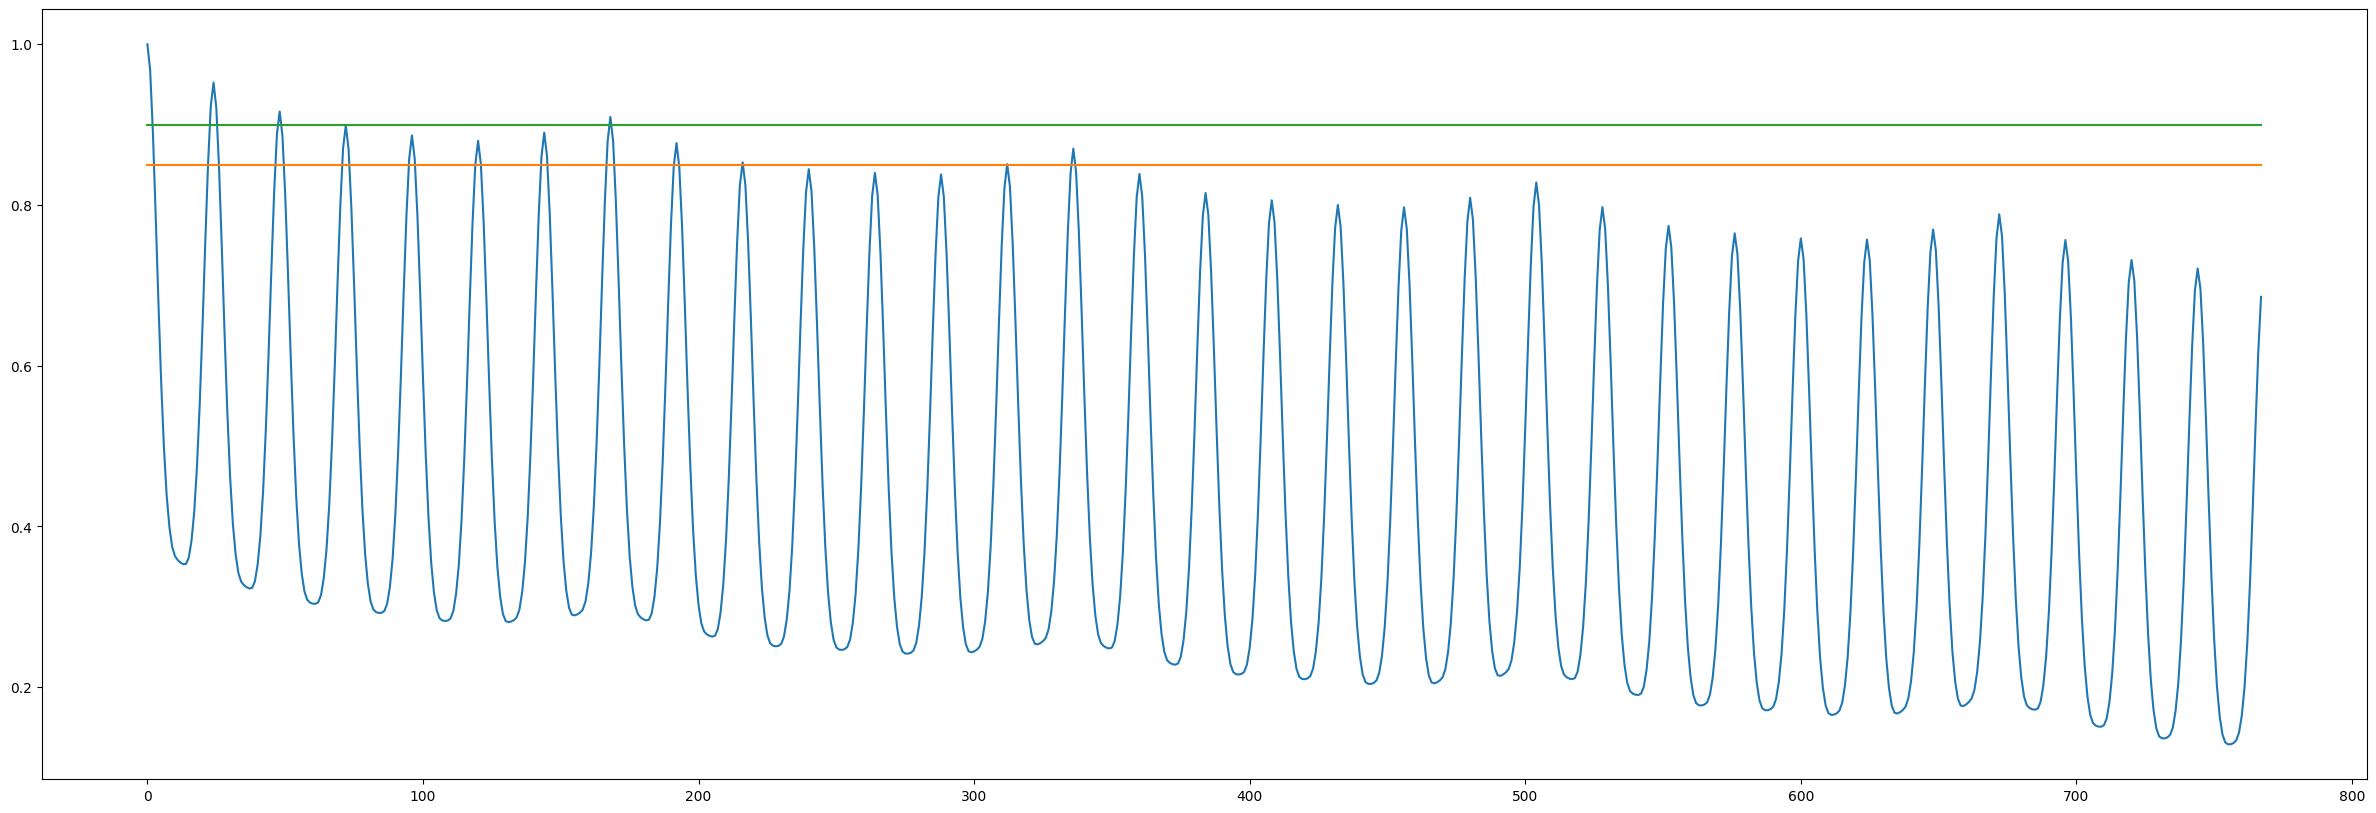

In [79]:
autocorr_list = []
days = 32
lags = 24 * days
for lag in range(lags):
  autocorr_list.append(data_df["TOTAL_CONS"].autocorr(lag=lag))

autocorr = np.array(autocorr_list)
plt.figure(figsize=(30, 10))
plt.plot(autocorr)
plt.plot(0.85 * np.ones(lags))
plt.plot(0.9 * np.ones(lags))
plt.show()

In [80]:
data_df_scaled, scaler = scale_data(data_df,
                                    START_TRAIN_DATE,
                                    END_VAL_DATE,
                                    START_TEST_DATE,
                                    END_TEST_DATE)

target_df = reframe_target(data_df_scaled[TARGET], 
                           SKIP_STEPS_FORWARD, 
                           LAST_STEP_FORWARD+1)

exog_df = reframe_exog_data(data_df_scaled[FUTR_COLS], 
                            LAST_STEP_FORWARD, 
                            LAST_STEP_BACK+STEPS_FORWARD)

hist_target_df = reframe_data(data_df_scaled[TARGET], 
                              LAST_STEP_BACK)

cm_index = target_df.index.intersection(exog_df.index).intersection(hist_target_df.index)
target_df = target_df.loc[cm_index]
exog_df = exog_df.loc[cm_index].iloc[:, ::-1]
hist_target_df = hist_target_df.loc[cm_index].iloc[:, ::-1]

Y_df = pd.concat([hist_target_df, target_df], axis=1)

In [81]:
exog_df.iloc[:1, :]

,temp_(t+264)_(t-167),temp_(t+264)_(t-166),temp_(t+264)_(t-165),temp_(t+264)_(t-164),temp_(t+264)_(t-163),temp_(t+264)_(t-162),temp_(t+264)_(t-161),temp_(t+264)_(t-160),temp_(t+264)_(t-159),temp_(t+264)_(t-158),...,Weekend_(t+264)_(t-9),Weekend_(t+264)_(t-8),Weekend_(t+264)_(t-7),Weekend_(t+264)_(t-6),Weekend_(t+264)_(t-5),Weekend_(t+264)_(t-4),Weekend_(t+264)_(t-3),Weekend_(t+264)_(t-2),Weekend_(t+264)_(t-1),Weekend_(t+264)_(t-0)
Timestamp,,,,,,,,,,,,,,,,,,,,,
2010-10-07 23:00:00,0.508604,0.49761,0.495698,0.486855,0.486616,0.48088,0.493069,0.491635,0.504541,0.511711,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
hours = 264 - 95
timestamp = pd.to_datetime('2010-10-04 23:00:00') + pd.to_timedelta(hours, 'h')
data_df_scaled[data_df_scaled.index == timestamp]

,TOTAL_CONS,Weekend,Holiday,temp
Timestamp,,,,
2010-10-12,0.23388,0.0,0.0,0.508604


In [83]:
hist_target_df.iloc[:1, :]

,TOTAL_CONS_(t-143),TOTAL_CONS_(t-142),TOTAL_CONS_(t-141),TOTAL_CONS_(t-140),TOTAL_CONS_(t-139),TOTAL_CONS_(t-138),TOTAL_CONS_(t-137),TOTAL_CONS_(t-136),TOTAL_CONS_(t-135),TOTAL_CONS_(t-134),...,TOTAL_CONS_(t-9),TOTAL_CONS_(t-8),TOTAL_CONS_(t-7),TOTAL_CONS_(t-6),TOTAL_CONS_(t-5),TOTAL_CONS_(t-4),TOTAL_CONS_(t-3),TOTAL_CONS_(t-2),TOTAL_CONS_(t-1),TOTAL_CONS_(t-0)
Timestamp,,,,,,,,,,,,,,,,,,,,,
2010-10-07 23:00:00,0.217594,0.174883,0.147215,0.134322,0.129806,0.132204,0.144983,0.168488,0.239279,0.314247,...,0.401839,0.353099,0.32479,0.336967,0.379186,0.484206,0.514,0.441221,0.35678,0.282172


In [84]:
target_df.iloc[:1, :]

,TOTAL_CONS_(t+241),TOTAL_CONS_(t+242),TOTAL_CONS_(t+243),TOTAL_CONS_(t+244),TOTAL_CONS_(t+245),TOTAL_CONS_(t+246),TOTAL_CONS_(t+247),TOTAL_CONS_(t+248),TOTAL_CONS_(t+249),TOTAL_CONS_(t+250),...,TOTAL_CONS_(t+255),TOTAL_CONS_(t+256),TOTAL_CONS_(t+257),TOTAL_CONS_(t+258),TOTAL_CONS_(t+259),TOTAL_CONS_(t+260),TOTAL_CONS_(t+261),TOTAL_CONS_(t+262),TOTAL_CONS_(t+263),TOTAL_CONS_(t+264)
Timestamp,,,,,,,,,,,,,,,,,,,,,
2010-10-07 23:00:00,0.178031,0.124914,0.088468,0.078266,0.077965,0.08629,0.144873,0.24287,0.301228,0.370772,...,0.383718,0.335437,0.322872,0.328787,0.365654,0.456177,0.471876,0.409629,0.316477,0.271601


In [95]:
# Y_df.corr().style.background_gradient(cmap='coolwarm')

In [86]:
Y_train_df, Y_val_df, Y_test_df = split_data(Y_df,
                                            START_TRAIN_DATE,
                                            END_TRAIN_DATE,
                                            START_VAL_DATE,
                                            END_VAL_DATE,
                                            START_TEST_DATE,
                                            END_TEST_DATE)

exog_train_df, exog_val_df, exog_test_df = split_data(exog_df,
                                                      START_TRAIN_DATE,
                                                      END_TRAIN_DATE,
                                                      START_VAL_DATE,
                                                      END_VAL_DATE,
                                                      START_TEST_DATE,
                                                      END_TEST_DATE)

exog_train_3D = create3Dinput(exog_train_df, LAST_STEP_BACK+STEPS_FORWARD).transpose(0, 2, 1)
exog_val_3D = create3Dinput(exog_val_df, LAST_STEP_BACK+STEPS_FORWARD).transpose(0, 2, 1)
exog_test_3D = create3Dinput(exog_test_df, LAST_STEP_BACK+STEPS_FORWARD).transpose(0, 2, 1)

train_dataset = LoadDataset(exog_3D=exog_train_3D.copy(), 
                            Y_df=Y_train_df)
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataset = LoadDataset(exog_3D=exog_val_3D.copy(), 
                          Y_df=Y_val_df)
val_dataloader = DataLoader(dataset=val_dataset, 
                            batch_size=BATCH_SIZE,
                            shuffle=False)

test_dataset = LoadDataset(exog_3D=exog_test_3D.copy(), 
                           Y_df=Y_test_df)
test_dataloader = DataLoader(dataset=test_dataset, 
                             batch_size=BATCH_SIZE,
                             shuffle=False)

device = "cuda" if t.cuda.is_available() else "cpu"

(54385, 168, 3)
(8760, 168, 3)
(8497, 168, 3)


# Train

In [88]:
theta_h = int(512)
n_stacks = int(2)
n_blocks_per_stack = int(1)
n_layers_per_block = int(2)

stack_types = n_stacks * ['identity']
n_blocks = n_blocks_per_stack * np.ones(n_stacks, dtype=type(theta_h))
n_layers = n_layers_per_block * np.ones(n_stacks, dtype=type(theta_h))

basic_list = list(theta_h * np.ones(n_layers_per_block, dtype=type(theta_h)))
n_theta_hidden = []
for i in range(n_stacks):
  n_theta_hidden.append(basic_list)

n_freq_downsample = 2 * np.ones(n_stacks, dtype=type(theta_h))
n_pool_kernel_size = 3 * np.ones(n_stacks, dtype=type(theta_h))

model = NHITS(
    n_time_in=LAST_STEP_BACK,
    n_time_out=STEPS_FORWARD,
    n_s=0,
    n_x=exog_train_3D.shape[1],
    n_s_hidden=0,
    stack_types=stack_types,
    n_blocks=n_blocks,
    n_layers=n_layers,
    n_theta_hidden=n_theta_hidden,
    n_pool_kernel_size=n_pool_kernel_size,
    n_freq_downsample=n_freq_downsample,
    pooling_mode='max',
    interpolation_mode=f'cubic-{BATCH_SIZE}',
    dropout_prob_theta=0,
    activation=nn.ReLU(),
    batch_normalization=True,
    shared_weights=False
).to(device)

# model.state_dict

In [89]:
optimizer = t.optim.Adam(params=model.parameters(),
                         lr=1e-3,
                         weight_decay=0)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.33, patience=10, verbose=True)

!rm -rf "model.pth"

model_results = train(model=model, 
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      scheduler=scheduler,
                      epochs=EPOCHS,
                      patience=PATIENCE,
                      device=device,
                      path=PATH)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 | Loss: 44.5743 | Val loss: 11.5761 - *Checkpoint*
Epoch: 1 | Loss: 20.4231 | Val loss: 10.4060 - *Checkpoint*
Epoch: 2 | Loss: 18.3389 | Val loss: 9.6441 - *Checkpoint*
Epoch: 3 | Loss: 16.9225 | Val loss: 9.3747 - *Checkpoint*
Epoch: 4 | Loss: 16.3901 | Val loss: 12.0691
Epoch: 5 | Loss: 15.9756 | Val loss: 8.8880 - *Checkpoint*
Epoch: 6 | Loss: 15.5665 | Val loss: 7.7526 - *Checkpoint*
Epoch: 7 | Loss: 14.9670 | Val loss: 7.8100
Epoch: 8 | Loss: 14.5499 | Val loss: 8.4405
Epoch: 9 | Loss: 14.0805 | Val loss: 10.3426
Epoch: 10 | Loss: 14.2701 | Val loss: 8.8828
Epoch: 11 | Loss: 13.9754 | Val loss: 9.3952
Epoch: 12 | Loss: 14.0824 | Val loss: 9.4644
Epoch: 13 | Loss: 14.0307 | Val loss: 7.2755 - *Checkpoint*
Epoch: 14 | Loss: 13.5672 | Val loss: 7.8102
Epoch: 15 | Loss: 13.4386 | Val loss: 7.3150
Epoch: 16 | Loss: 13.3661 | Val loss: 8.4294
Epoch: 17 | Loss: 13.2694 | Val loss: 7.2728 - *Checkpoint*
Epoch: 18 | Loss: 13.0596 | Val loss: 8.7046
Epoch: 19 | Loss: 13.3745 | Val

# Inference

In [90]:
checkpoint = t.load("model.pth")
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
# model.to('cpu')
model.eval()
with t.inference_mode():
  y_test_scaled, test_preds_scaled = model(S=None,
                                           X=t.tensor(exog_test_3D.copy(), dtype=t.float32, device=device),
                                           Y=t.tensor(Y_test_df.values, dtype=t.float32, device=device))

y_test_scaled = y_test_scaled.to('cpu').squeeze().numpy()
test_preds_scaled = test_preds_scaled.to('cpu').squeeze().numpy()

In [91]:
test_preds_df_scaled = pd.DataFrame(test_preds_scaled, columns=np.arange(1, STEPS_FORWARD+1), index=Y_test_df.index)
test_preds_df = pd.DataFrame(columns=np.arange(1, STEPS_FORWARD+1), index=test_preds_df_scaled.index)
for i, col in enumerate(test_preds_df_scaled.columns):
  test_preds_df[i+1] = scaler.data_min_[TARGET_POS] + test_preds_df_scaled[col].to_numpy() * (scaler.data_max_[TARGET_POS] - scaler.data_min_[TARGET_POS])

real_df_scaled = pd.DataFrame(y_test_scaled, columns=np.arange(1, STEPS_FORWARD+1), index=Y_test_df.index)
real_df = pd.DataFrame(columns=np.arange(1, STEPS_FORWARD+1), index=test_preds_df.index)
for i, col in enumerate(real_df_scaled.columns):
  real_df[i+1] = scaler.data_min_[TARGET_POS] + real_df_scaled[col].to_numpy() * (scaler.data_max_[TARGET_POS] - scaler.data_min_[TARGET_POS])

In [92]:
mape_list = list()
step_results_dict = {}
for step in range(1, STEPS_FORWARD + 1):
  step_index = real_df.index + pd.to_timedelta(SKIP_STEPS_FORWARD + step, 'h')
  step_results_df = pd.DataFrame(
      {
          "real": real_df.loc[:, step].to_numpy(),
          "predictions": test_preds_df.loc[:, step].to_numpy()
      },
      index=step_index
  )
  step_results_df['abs_error'] = abs(step_results_df['real'] - step_results_df['predictions'])
  step_results_df['ape'] = np.where(step_results_df['real'] == 0, np.NaN, 100 * step_results_df['abs_error']/step_results_df['real'])
  step_mape = step_results_df['ape'].mean()
  mape_list.append(step_mape)
  print(f"Step {step} -> MAPE = {step_mape}")

  step_results_dict[step] = step_results_df
mape = np.array(mape_list).mean()
print(f"\nMAPE = {mape}")

Step 1 -> MAPE = 9.359036445617676
Step 2 -> MAPE = 9.375110626220703
Step 3 -> MAPE = 9.196043968200684
Step 4 -> MAPE = 8.936189651489258
Step 5 -> MAPE = 8.758378028869629
Step 6 -> MAPE = 8.713332176208496
Step 7 -> MAPE = 8.75026798248291
Step 8 -> MAPE = 8.819698333740234
Step 9 -> MAPE = 8.85266399383545
Step 10 -> MAPE = 8.706626892089844
Step 11 -> MAPE = 8.414204597473145
Step 12 -> MAPE = 8.305913925170898
Step 13 -> MAPE = 8.442703247070312
Step 14 -> MAPE = 8.502984046936035
Step 15 -> MAPE = 8.367687225341797
Step 16 -> MAPE = 8.376445770263672
Step 17 -> MAPE = 8.426677703857422
Step 18 -> MAPE = 8.441143035888672
Step 19 -> MAPE = 8.417936325073242
Step 20 -> MAPE = 8.693720817565918
Step 21 -> MAPE = 9.07282543182373
Step 22 -> MAPE = 9.40510082244873
Step 23 -> MAPE = 9.468292236328125
Step 24 -> MAPE = 9.4076566696167

MAPE = 8.800443649291992


In [93]:
step_results_dict[1]

,real,predictions,abs_error,ape
Timestamp,,,,
2017-12-31 01:00:00,4233.823242,4885.202148,651.378906,15.385123
2017-12-31 02:00:00,4176.828125,4369.630859,192.802734,4.616008
2017-12-31 03:00:00,4193.562012,4284.616211,91.054199,2.171285
2017-12-31 04:00:00,4168.711914,4113.681641,55.030273,1.320079
2017-12-31 05:00:00,4181.110840,4219.878906,38.768066,0.927219
...,...,...,...,...
2018-12-19 21:00:00,5953.751953,6693.890625,740.138672,12.431466
2018-12-19 22:00:00,5508.688965,5954.254395,445.565430,8.088411
2018-12-19 23:00:00,5176.446777,5457.796875,281.350098,5.435197


In [94]:
data_df.loc[step_results_dict[1].index[0]]['TOTAL_CONS']

4233.823